In [1]:
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import pandas as pd
import os
import time
from datetime import timedelta
import rasterio.warp as rasteriowarp

In [2]:
SATELLITE_DATA_PATH = os.path.expanduser('~/data/EUMETSAT/reprojected_subsetted/')
PV_DATA_FILENAME = os.path.expanduser('~/data/pvoutput.org/UK_PV_timeseries_batch.nc')
PV_METADATA_FILENAME = os.path.expanduser('~/data/pvoutput.org/UK_PV_metadata.csv')

DST_CRS = {
    'ellps': 'WGS84',
    'proj': 'tmerc',  # Transverse Mercator
    'units': 'm'  # meters
}

# Geospatial boundary in Transverse Mercator projection (meters)
SOUTH = 5513500
NORTH = 6613500
WEST =  -889500
EAST =   410500

## Load and convert PV metadata

In [3]:
pv_metadata = pd.read_csv(PV_METADATA_FILENAME, index_col='system_id')
pv_metadata.dropna(subset=['longitude', 'latitude'], how='any', inplace=True)

In [4]:
# Convert lat lons to Transverse Mercator
pv_metadata['x'], pv_metadata['y'] = rasteriowarp.transform(
    src_crs={'init': 'EPSG:4326'},
    dst_crs=DST_CRS,
    xs=pv_metadata['longitude'].values,
    ys=pv_metadata['latitude'].values)

# Filter 3 PV systems which apparently aren't in the UK!
pv_metadata = pv_metadata[
    (pv_metadata.x >= WEST) &
    (pv_metadata.x <= EAST) &
    (pv_metadata.y <= NORTH) &
    (pv_metadata.y >= SOUTH)]

len(pv_metadata)

2548

## Load and normalise PV power data

In [5]:
%%time
pv_power = xr.load_dataset(PV_DATA_FILENAME)

CPU times: user 13.2 s, sys: 1.72 s, total: 15 s
Wall time: 15 s


In [6]:
pv_power_selected = pv_power.loc[dict(datetime=slice('2018-06-01', '2019-07-01'))]

In [7]:
pv_power_df = pv_power_selected.to_dataframe().dropna(axis='columns', how='all')
pv_power_df = pv_power_df.clip(lower=0, upper=5E7)
pv_power_df.columns = [np.int64(col) for col in pv_power_df.columns]
pv_power_df = pv_power_df.tz_localize('Europe/London').tz_convert('UTC')

In [8]:
del pv_power
del pv_power_selected

In [9]:
# A bit of hand-crafted cleaning
pv_power_df[30248]['2018-10-29':'2019-01-03'] = np.NaN

In [10]:
# Only pick PV systems for which we have good metadata
def align_pv_system_ids(pv_metadata, pv_power_df):
    pv_system_ids = pv_metadata.index.intersection(pv_power_df.columns)
    pv_system_ids = np.sort(pv_system_ids)

    pv_power_df = pv_power_df[pv_system_ids]
    pv_metadata = pv_metadata.loc[pv_system_ids]
    return pv_metadata, pv_power_df
    
pv_metadata, pv_power_df = align_pv_system_ids(pv_metadata, pv_power_df)

In [11]:
# Scale to the range [0, 1]
pv_power_min = pv_power_df.min()
pv_power_max = pv_power_df.max()

pv_power_df -= pv_power_min
pv_power_df /= pv_power_max

In [12]:
# Drop systems which are producing over night
NIGHT_YIELD_THRESHOLD = 0.4
night_hours = list(range(21, 24)) + list(range(0, 4))
bad_systems = np.where(
    (pv_power_df[pv_power_df.index.hour.isin(night_hours)] > NIGHT_YIELD_THRESHOLD).sum()
)[0]
bad_systems = pv_power_df.columns[bad_systems]
print(len(bad_systems), 'bad systems found.')

#ax = pv_power_df[bad_systems].plot(figsize=(40, 10), alpha=0.5)
#ax.set_title('Bad PV systems');

31 bad systems found.


In [13]:
pv_power_df.drop(bad_systems, axis='columns', inplace=True)

In [14]:
%%time
# Interpolate up to 15 minutes ahead.
# pv_power_df = pv_power_df.interpolate(limit=3)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.58 µs


In [15]:
# Align again, after removing dud PV systems
pv_metadata, pv_power_df = align_pv_system_ids(pv_metadata, pv_power_df)

In [16]:
len(pv_power_df.columns)

913

In [17]:
#pv_power_df.plot(figsize=(40, 10), alpha=0.5, legend=False);

In [18]:
pv_power_df.head()

,690,709,973,1364,1556,1627,1646,1647,1872,1883,...,67769,67927,67933,67948,67969,68000,68212,68218,68219,68324
datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-01 02:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01 02:35:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01 02:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01 02:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01 02:50:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
pv_metadata.query('status_interval_minutes == 5')

,system_name,system_size_watts,postcode,number_of_panels,panel_power_watts,panel_brand,num_inverters,inverter_power_watts,inverter_brand,orientation,...,install_date,latitude,longitude,status_interval_minutes,number_of_panels_secondary,panel_power_watts_secondary,orientation_secondary,array_tilt_degrees_secondary,x,y
system_id,,,,,,,,,,,,,,,,,,,,,
709,Grove Cottages,2460,RG4,12,205,Romag PowerGlaz SMT6(54)P,1,3000,SMA Sunny Boy 3000TL,SE,...,2010-09-28 00:00:00,51.485329,-0.967526,5,0,0,NaN,NaN,-67206.360476,5.706524e+06
973,number38,4000,WA11,16,250,Sungrid/SG250M6,1,3800,Sunny Boy 3800,SW,...,2011-01-13 00:00:00,53.467927,-2.675806,5,0,0,NaN,NaN,-177679.149748,5.930031e+06
1364,Bugs Bottom,3700,RG4,20,185,Sharp NU-185 (E1),1,3800,Diehl 3800S,S,...,2010-06-03 00:00:00,51.490415,-0.983276,5,0,0,NaN,NaN,-68292.765254,5.707104e+06
1556,MK Solar Power Station,3870,MK5,18,215,Schuco,1,3800,SMA SB3800,SW,...,2011-02-18 00:00:00,52.020855,-0.780158,5,0,0,NaN,NaN,-53554.401795,5.765951e+06
1627,KetteringUK,2820,NN15,12,235,Sanyo HIT-N235SE10,1,3000,SMA 3000 TL20,SE,...,2011-04-12 00:00:00,52.399319,-0.730248,5,0,0,NaN,NaN,-49704.175747,5.808027e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68000,McPat,3960,NE25,12,330,Canadian Solar CS1H-330MS-BF,1,3680,SolarEdge SE3680H-RW000BNN4,S,...,2019-06-12 00:00:00,55.050000,-1.480000,5,0,0,NaN,NaN,-94589.889391,6.103798e+06
68212,PA145,11970,G77,42,285,JA Solar,2,11000,Solaredge SE6000 SE5000,S,...,2015-09-15 00:00:00,55.770000,-4.330000,5,0,0,NaN,NaN,-271667.922724,6.191449e+06
68218,Dundonald,8835,KA2,31,285,JA Solar,2,8000,SolarEdge 4000 4000,S,...,2016-01-01 00:00:00,55.590000,-4.560000,5,0,0,NaN,NaN,-287405.928333,6.172358e+06


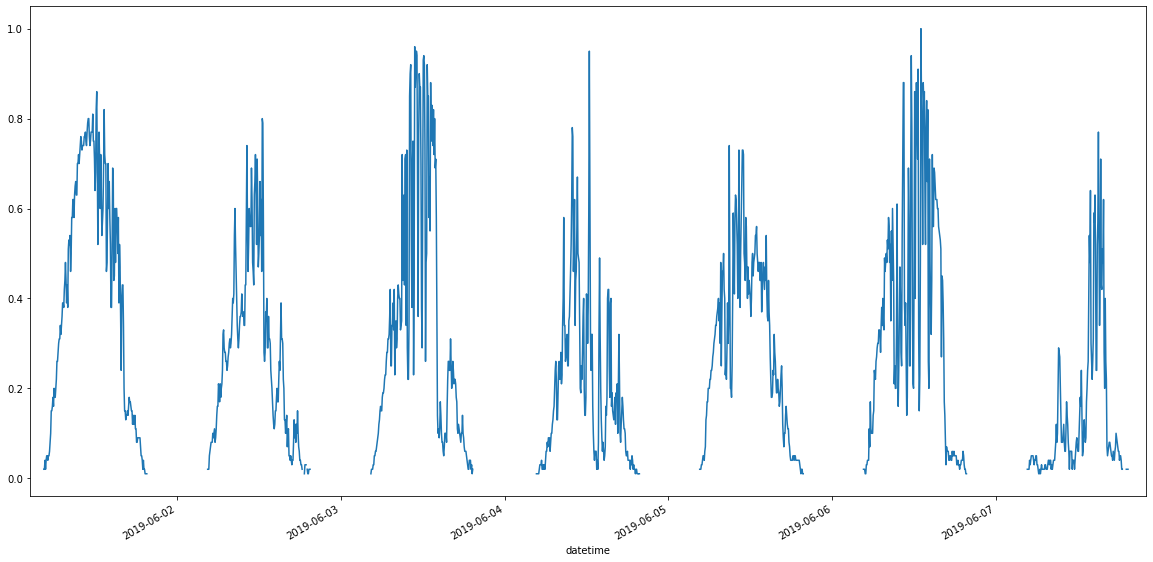

In [31]:
pv_system_id = 709
pv_power_df[pv_system_id]["2019-06-01":"2019-06-07"].plot(figsize=(20, 10))

## Load satellite data

In [19]:
from glob import glob
from torch.utils.data import Dataset
from datetime import datetime

In [20]:
RECTANGLE_WIDTH_M = 128000 # in meters
RECTANGLE_HEIGHT_M = RECTANGLE_WIDTH_M

METERS_PER_PIXEL = 1000
RECTANGLE_WIDTH_PIXELS = np.int(RECTANGLE_WIDTH_M / METERS_PER_PIXEL)
RECTANGLE_HEIGHT_PIXELS = np.int(RECTANGLE_HEIGHT_M / METERS_PER_PIXEL)

SAT_IMAGE_MEAN = 20.444992
SAT_IMAGE_STD = 8.766013


def get_rectangle(data_array, centre_x, centre_y, width=RECTANGLE_WIDTH_M, height=RECTANGLE_HEIGHT_M):
    half_width = width / 2
    half_height = height / 2

    north = centre_y + half_height
    south = centre_y - half_height
    east = centre_x + half_width
    west = centre_x - half_width

    return data_array.loc[dict(
        x=slice(west, east), 
        y=slice(north, south))]


class SatelliteLoader(Dataset):
    """
    Attributes:
        index: pd.Series which maps from UTC datetime to full filename of satellite data.
        _data_array_cache: The last lazily opened xr.DataArray that __getitem__ was asked to open.
            Useful so that we don't have to re-open the DataArray if we're asked to get
            data from the same file on several different calls.
    """
    def __init__(self, file_pattern):
        self._load_sat_index(file_pattern)
        self._data_array_cache = None
        self._last_filename_requested = None
        
    def __getitem__(self, dt: datetime) -> xr.DataArray:
        """Returns lazily-opened DataArray"""
        sat_filename = self.index[dt]
        if sat_filename != self._last_filename_requested:
            self._data_array_cache = xr.open_dataarray(sat_filename)
            self._last_filename_requested = sat_filename
        return self._data_array_cache.sel(time=dt)
    
    def close(self):
        if self._data_array_cache is not None:
            self._data_array_cache.close()
        
    def __len__(self):
        return len(self.index)
        
    def _load_sat_index(self, file_pattern):
        """Opens all satellite files in `file_pattern` and loads all their datetime indicies into self.index."""
        sat_filenames = glob(file_pattern)
        sat_filenames.sort()
        
        n_filenames = len(sat_filenames)
        sat_index = []
        for i_filename, sat_filename in enumerate(sat_filenames):
            if i_filename % 10 == 0 or i_filename == (n_filenames - 1):
                print('\r {:5d} of {:5d}'.format(i_filename + 1, n_filenames), end='', flush=True)
            data_array = xr.open_dataarray(sat_filename, drop_variables=['x', 'y'])
            sat_index.extend([(sat_filename, t) for t in data_array.time.values])

        sat_index = pd.DataFrame(sat_index, columns=['filename', 'datetime']).set_index('datetime').squeeze()
        assert not any(sat_index.index.duplicated())
        self.index = sat_index.tz_localize('UTC')
        
    def get_rectangles_for_all_data(self, centre_x, centre_y, width=RECTANGLE_WIDTH_M, height=RECTANGLE_HEIGHT_M):
        """Iterate through all satellite filenames and load rectangle of imagery."""
        sat_filenames = np.sort(np.unique(self.index.values))
        for sat_filename in sat_filenames:
            data_array = xr.open_dataarray(sat_filename)
            yield get_rectangle(data_array, time, centre_x, centre_y, width, height)
        
    def get_rectangle(self, time, centre_x, centre_y, width=RECTANGLE_WIDTH_M, height=RECTANGLE_HEIGHT_M):
        data_array = self[time]
        return get_rectangle(data_array, centre_x, centre_y, width, height)

In [21]:
%%time
sat_loader = SatelliteLoader(os.path.join(SATELLITE_DATA_PATH, '*.nc'))
print()

  3815 of  3815
CPU times: user 14.5 s, sys: 655 ms, total: 15.1 s
Wall time: 17.9 s


In [22]:
len(sat_loader)

45745

## Plot a test

In [32]:
# Test get rectangle
dt = pd.Timestamp('2019-06-01 10:00')
x, y = pv_metadata.loc[pv_system_id][['x', 'y']]

In [35]:
%%time
sat_data = sat_loader.get_rectangle(time=dt, centre_x=x, centre_y=y, width=512000, height=512000)

CPU times: user 3.28 ms, sys: 0 ns, total: 3.28 ms
Wall time: 2.79 ms


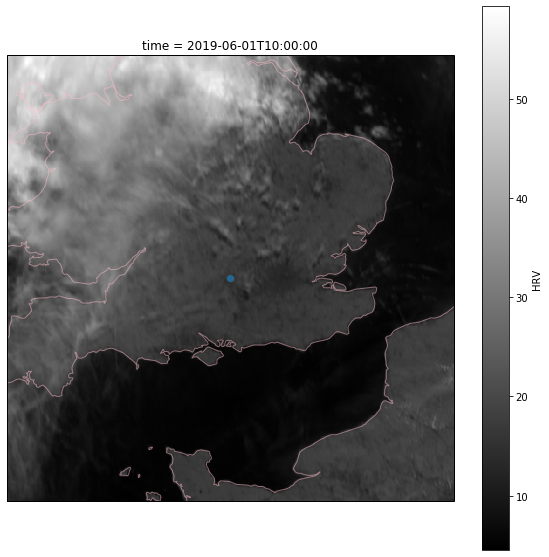

In [36]:
fig = plt.figure(figsize=(10, 10))
crs = ccrs.TransverseMercator()
ax = plt.axes(projection=crs)
ax.coastlines(resolution='10m', alpha=0.5, color='pink')

sat_data.plot.imshow(ax=ax, cmap='gray', origin='upper', add_colorbar=True)
ax.scatter(x=x, y=y, alpha=0.7);

## Align satellite datetime index with PV datetime index

In [49]:
DST_WIDTH = 33
DST_HEIGHT = DST_WIDTH
DST_START = "2019-06-01"
DST_END = "2019-06-08"

In [79]:
selected_pv_power = pv_power_df[pv_system_id][DST_START:DST_END].dropna()

In [81]:
selected_pv_power.index.name = 'time'

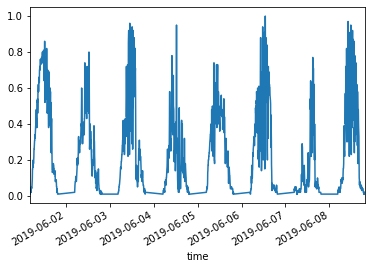

In [82]:
selected_pv_power.plot()

In [47]:
selected_dt_index = selected_pv_power.intersection(sat_loader.index.index)

In [135]:
selected_dt_index

DatetimeIndex(['2019-06-01 04:20:00+00:00', '2019-06-01 04:30:00+00:00',
               '2019-06-01 04:35:00+00:00', '2019-06-01 04:40:00+00:00',
               '2019-06-01 04:45:00+00:00', '2019-06-01 04:50:00+00:00',
               '2019-06-01 04:55:00+00:00', '2019-06-01 05:00:00+00:00',
               '2019-06-01 05:05:00+00:00', '2019-06-01 05:10:00+00:00',
               ...
               '2019-06-08 18:45:00+00:00', '2019-06-08 18:50:00+00:00',
               '2019-06-08 18:55:00+00:00', '2019-06-08 19:00:00+00:00',
               '2019-06-08 19:05:00+00:00', '2019-06-08 19:10:00+00:00',
               '2019-06-08 19:15:00+00:00', '2019-06-08 19:20:00+00:00',
               '2019-06-08 19:25:00+00:00', '2019-06-08 19:35:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=1441, freq=None)

## Create xr.DataSet to hold the PV data and the sat data

In [56]:
sat_data = sat_loader.get_rectangle(time=dt, centre_x=x, centre_y=y, width=DST_WIDTH * 1000, height=DST_HEIGHT * 1000)

In [59]:
sat_data

<xarray.DataArray 'HRV' (y: 33, x: 33)>
array([[18.210373, 17.789564, 17.106173, ..., 15.523782, 15.446493, 15.098954],
       [18.289354, 18.2178  , 17.407436, ..., 14.852267, 14.803618, 14.426476],
       [18.302975, 18.412405, 17.793482, ..., 14.806539, 14.788804, 14.451786],
       ...,
       [16.05905 , 15.874103, 15.815896, ..., 13.690767, 13.597006, 13.174734],
       [16.0678  , 15.86184 , 15.720858, ..., 13.054368, 12.579082, 12.000417],
       [16.36938 , 16.37378 , 16.318743, ..., 12.997512, 12.112655, 11.154687]],
      dtype=float32)
Coordinates:
  * x        (x) int64 -83500 -82500 -81500 -80500 ... -53500 -52500 -51500
  * y        (y) int64 5722500 5721500 5720500 ... 5692500 5691500 5690500
    time     datetime64[ns] 2019-06-01T10:00:00

In [61]:
from collections import OrderedDict

In [64]:
selected_dt_index.name = 'time'

In [65]:
dims = OrderedDict()
dims['time'] = selected_dt_index
dims['y'] = sat_data.y
dims['x'] = sat_data.x

shape = [len(values) for values in dims.values()]
data = np.full(shape, fill_value=np.nan, dtype=np.float32)

data_array = xr.DataArray(
    data,
    coords=dims,
    dims=dims.keys(),
    name='HRV')

In [69]:
data_array.loc[dt]

<xarray.DataArray 'HRV' (y: 33, x: 33)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2019-06-01T10:00:00
  * y        (y) int64 5722500 5721500 5720500 ... 5692500 5691500 5690500
  * x        (x) int64 -83500 -82500 -81500 -80500 ... -53500 -52500 -51500

In [71]:
n = len(selected_dt_index)
for i, dt in enumerate(selected_dt_index):
    print('\r {:4d} of {:4d}'.format(i, n), end='', flush=True)
    sat_data = sat_loader.get_rectangle(time=dt, centre_x=x, centre_y=y, width=DST_WIDTH * 1000, height=DST_HEIGHT * 1000)
    data_array.loc[dt] = sat_data.values

 1440 of 1441

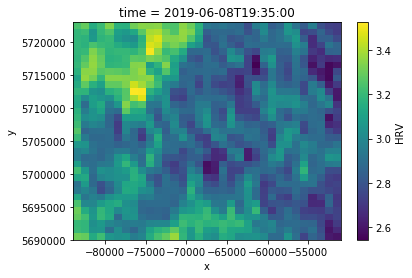

In [74]:
data_array.loc[dt].plot.imshow()

In [93]:
pv_metadata.loc[pv_system_id]

system_name                                Grove Cottages
system_size_watts                                    2460
postcode                                              RG4
number_of_panels                                       12
panel_power_watts                                     205
panel_brand                     Romag PowerGlaz SMT6(54)P
num_inverters                                           1
inverter_power_watts                                 3000
inverter_brand                       SMA Sunny Boy 3000TL
orientation                                            SE
array_tilt_degrees                                     18
shade                                                 Low
install_date                          2010-09-28 00:00:00
latitude                                          51.4853
longitude                                       -0.967526
status_interval_minutes                                 5
number_of_panels_secondary                              0
panel_power_wa

In [137]:
attrs = pv_metadata.loc[pv_system_id].dropna().to_dict()
attrs['pv_system_id'] = pv_system_id
attrs['timezone'] = 'UTC'
attrs.update({'crs_' + k: v for k, v in DST_CRS.items()})

dataset = xr.Dataset(
    {
        'sat_images': data_array,
         'pv_power': selected_pv_power.to_xarray()
    },
    attrs=attrs
)

dataset['time'] = pd.DatetimeIndex(dataset.time.values)
dataset

<xarray.Dataset>
Dimensions:     (time: 1441, x: 33, y: 33)
Coordinates:
  * time        (time) datetime64[ns] 2019-06-01T04:20:00 ... 2019-06-08T19:35:00
  * y           (y) int64 5722500 5721500 5720500 ... 5692500 5691500 5690500
  * x           (x) int64 -83500 -82500 -81500 -80500 ... -53500 -52500 -51500
Data variables:
    sat_images  (time, y, x) float32 2.8968804 2.918428 ... 2.614778 2.594803
    pv_power    (time) float32 0.01 0.02 0.02 0.04 0.02 ... 0.01 0.01 0.01 0.02
Attributes:
    system_name:                  Grove Cottages
    system_size_watts:            2460
    postcode:                     RG4
    number_of_panels:             12
    panel_power_watts:            205
    panel_brand:                  Romag PowerGlaz SMT6(54)P
    num_inverters:                1
    inverter_power_watts:         3000
    inverter_brand:               SMA Sunny Boy 3000TL
    orientation:                  SE
    array_tilt_degrees:           18.0
    shade:                        L

In [138]:
%%time
compression = {'zlib': True, 'complevel': 5}
encoding = {
    'sat_images': compression,
    'pv_power': compression
}
dst_filename = '/home/jack/data/processed_ml_training_data/seven_days_one_pv_and_33x33_images/pv_and_sat_data.nc'
dataset.to_netcdf(
    path=dst_filename,
    engine='netcdf4',
    encoding=encoding
)

CPU times: user 174 ms, sys: 0 ns, total: 174 ms
Wall time: 175 ms


## Load dataset

In [139]:
dataset = xr.load_dataset(dst_filename)

In [140]:
dataset

<xarray.Dataset>
Dimensions:     (time: 1441, x: 33, y: 33)
Coordinates:
  * time        (time) datetime64[ns] 2019-06-01T04:20:00 ... 2019-06-08T19:35:00
  * y           (y) int64 5722500 5721500 5720500 ... 5692500 5691500 5690500
  * x           (x) int64 -83500 -82500 -81500 -80500 ... -53500 -52500 -51500
Data variables:
    sat_images  (time, y, x) float32 2.8968804 2.918428 ... 2.614778 2.594803
    pv_power    (time) float32 0.01 0.02 0.02 0.04 0.02 ... 0.01 0.01 0.01 0.02
Attributes:
    system_name:                  Grove Cottages
    system_size_watts:            2460
    postcode:                     RG4
    number_of_panels:             12
    panel_power_watts:            205
    panel_brand:                  Romag PowerGlaz SMT6(54)P
    num_inverters:                1
    inverter_power_watts:         3000
    inverter_brand:               SMA Sunny Boy 3000TL
    orientation:                  SE
    array_tilt_degrees:           18.0
    shade:                        L

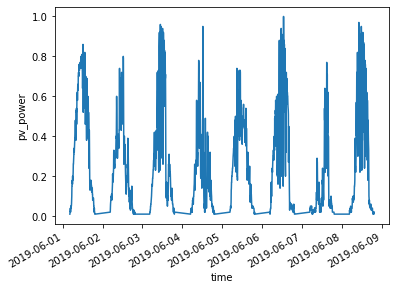

In [141]:
dataset.pv_power.plot()

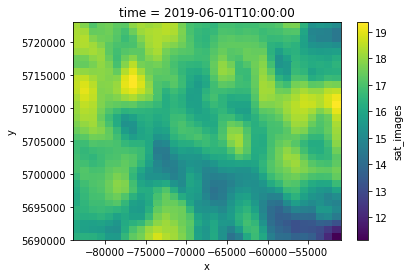

In [144]:
dataset.sat_images.loc['2019-06-01 10:00'].plot()